# Image Classifier using Convolutions

This notebook is an example notebook of using image data and classifying them into 2 or more classes.

Classifying images into labels is a long-lasting problem in almost all vector of industry. 

Here is a notebook to do the same using neural network model to classify the images with cyclic learning rate.

In [1]:
import keras, tensorflow, sys
keras.__version__, tensorflow.__version__, sys.version

Using TensorFlow backend.


('2.2.2',
 '1.10.0',
 '3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]')

In [2]:
# Packages for processing/ loading image files
from glob import glob 
import cv2
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Packages for the model
from keras.layers import LeakyReLU, Concatenate, concatenate, Lambda, UpSampling2D, Add, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization
from keras.models import Model,load_model
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# Import the snapshot builder callback file locally which is used for dynamic LR.
from snapshot import SnapshotCallbackBuilder

# Used for training on 1st GPU in a multi-GPU environment.
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

# Pacakge for viewing the images
from matplotlib import pyplot as plt
%matplotlib inline

## Function to load and process Image

Load image using opencv function imread(path, 1 for read as colour image).

Cv2 loads the image with B channel first. We converte this to R channel first.

Gaussian Blur is applied to image to have smoother transitions in image. 

In [3]:
# Preprocess image for of top view training/ detection
def load_and_process_image(img_file):
    im = cv2.imread(img_file, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.GaussianBlur(im, (5,5), 0)
    return im

## Dataset

The dataset for this notebook is taken from -> https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000 .

The dataset contains images of 7 different types of skin problems. There is total of 10000 jpg images, accompanied with a csv file conating the labels for the images.

In [4]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob("./skin-cancer-mnist-ham10000/*part*/*.jpg")}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
tile_df = pd.read_csv("./skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
5831,HAM_0001092,ISIC_0031962,nv,follow_up,50.0,male,lower extremity,./skin-cancer-mnist-ham10000\HAM10000_images_p...,Melanocytic nevi,4
473,HAM_0001057,ISIC_0032045,bkl,histo,75.0,female,back,./skin-cancer-mnist-ham10000\HAM10000_images_p...,Benign keratosis-like lesions,2
266,HAM_0004373,ISIC_0029014,bkl,histo,70.0,female,face,./skin-cancer-mnist-ham10000\HAM10000_images_p...,Benign keratosis-like lesions,2


In [6]:
tile_df.shape

(10015, 10)

In [7]:
X = np.array([load_and_process_image(x) for x in tile_df.path])
y = np.array(tile_df['cell_type_idx'])
X.shape, y.shape

((10015, 450, 600, 3), (10015,))

This shows the distribution of data in each of the class.

In [8]:
pd.Series(y).value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
dtype: int64

Sample Image

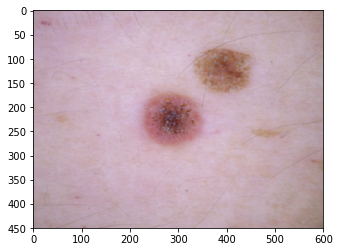

In [9]:
plt.imshow(X[49])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)
x_train.shape, x_test.shape

((9013, 450, 600, 3), (1002, 450, 600, 3))

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=3)
x_train.shape, x_val.shape

((8111, 450, 600, 3), (902, 450, 600, 3))

Computing class weights to weight the loss function according to the number of instances in each class.

In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

Converting y_train to one hot encoded vectors, which is required for the training of neural network.

In [13]:
y_train = to_categorical(y_train, len(lesion_type_dict))

## Model

A Convolution based model is used here to classify the images.

There are 6 convolution lyers with kernel size of (1,1) and number of kernels increases from 16 to 512.

Each Convolution layer is followed by batch normaliztion layer and Leaky ReLU activation.

Max pooling of features after each convolution block is performed to reduce the size of features by 2.

Finally dense layers are used to classify the features found from the convolution layer.

Categorical Cross entropy is used as the loss function and adam is the optimizer with cosine annealed learning rate.

In [14]:
# Initalize the Inception based model

inp = Input(X[0].shape)
x = Lambda(lambda x: x/255)(inp)

x = Conv2D(16,(1,1),padding='same',kernel_initializer="glorot_normal")(inp)
x = BatchNormalization(axis = 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), strides=2)(x)  #225,300


x = Conv2D(32,(1,1),padding='same',kernel_initializer="glorot_normal")(x)   
x = BatchNormalization(axis = 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), strides=2)(x) #112, 150


x = Conv2D(64,(1,1),padding='same',kernel_initializer="glorot_normal")(x)    
x = BatchNormalization(axis = 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), strides=2)(x) #56, 75


x = Conv2D(128,(1,1),padding='same',kernel_initializer="glorot_normal")(x)  
x = BatchNormalization(axis = 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x) #28, 37


x = Conv2D(256,(1,1),padding='same',kernel_initializer="glorot_normal")(x)    
x = BatchNormalization(axis = 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x) #14, 18


x = Conv2D(512,(1,1),padding='same',kernel_initializer="glorot_normal")(x)    
x = BatchNormalization(axis = 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x) #7, 9

x = Flatten()(x)

x = Dense(64, activation="relu", kernel_initializer="glorot_normal")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(16, activation="relu", kernel_initializer="glorot_normal")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

pred = Dense(len(lesion_type_dict), activation="softmax", kernel_initializer="glorot_normal")(x)

model = Model(inp, pred)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450, 600, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 450, 600, 16)      64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 450, 600, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 450, 600, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 225, 300, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 225, 300, 32)      544       
_________________________________________________________________
batch_normalization_2 (Batch (None, 225, 300, 32)      128       
__________

Initializing callback for tensorboard. 

In [15]:
from keras.callbacks import TensorBoard,LearningRateScheduler
tb = TensorBoard(log_dir='./logs/skin_cancer_snapshot', histogram_freq=0, batch_size=16, write_graph=True, write_grads=True, write_images=True,
                 embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [16]:
y_val = to_categorical(y_val, len(lesion_type_dict))

## Snapshot callback

In neural networks, the model weights can easily get stuck in a local minima if the model is trained with low learning rate throughout. In Adam the momentum does help to get out of a local minima but the model can still be stuck in a local minima.

To mitigate this problem, learning rate is increased to a high value (alpha_zero) after certain number of epochs (nb_epoch/M). After each cycle the learning rate is increased so that the model weights now come out of the local minima and go towards another, perhaps, better minima.

Generally because of the stochasticity in the training, the same model trained multiple times produce different results on the same test set. To mitigate this different snapshots of the model taken during training by above process is used to evaluate the results. In this notebook only the last model found in the training is used for the results, but according to the paper of [snapshot ensemble](https://arxiv.org/pdf/1704.00109.pdf) and my other experiments averaging results from mutiple snapshots will improve the results.

In [17]:
# Model parameters
# Number of model snapshots
M = 6
# Number of epochs
nb_epoch = T = 78
# Learning rate to be set at the start of a snapshot cycle
alpha_zero = 1e-3

snapshot = SnapshotCallbackBuilder(T, M, alpha_zero)
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_prefix = './conv_snpsht{}'.format(timestr)

# Train model
callbacks = [tb] + snapshot.get_callbacks(model_prefix = model_prefix)
model.fit(x_train, y_train, batch_size=16, epochs=nb_epoch, callbacks=callbacks, verbose=0,
          validation_data=[x_val, y_val], class_weight=class_weights)

## Model Prediction

In [18]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=-1)

In [19]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("f1_score:",f1_score(y_test, pred, average="macro"), "\n",
      "precision_score:",precision_score(y_test, pred, average="macro"), "\n",
      "recall_score:",recall_score(y_test, pred, average="macro"), "\n",
      "accuracy_score:",accuracy_score(y_test, pred))

Confusion Matrix:
 [[  7  12   5   1   6   0   5]
 [  2  31   9   0  11   0   7]
 [  2   3  53   0  41   0  12]
 [  1   2   1   4   2   0   0]
 [  1   3  18   0 620   0  12]
 [  0   0   0   0   0  13   1]
 [  2   0  14   1  54   0  46]]
f1_score: 0.5931103930878011 
 precision_score: 0.667154283794211 
 recall_score: 0.5511906632483304 
 accuracy_score: 0.7724550898203593
